<a href="https://colab.research.google.com/github/sokrypton/algosb_2021/blob/main/alphafold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

install a few things

In [1]:
%%bash
if [ ! -d af_backprop ]; then
  git clone https://github.com/sokrypton/af_backprop.git
  pip -q install biopython dm-haiku ml-collections py3Dmol
fi
if [ ! -d params ]; then
  mkdir params
  curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar | tar x -C params
fi
wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py

Cloning into 'af_backprop'...


In [1]:
import sys
sys.path.append('/content/af_backprop')

import numpy as np
import matplotlib.pyplot as plt
import py3Dmol

import jax
import jax.numpy as jnp

from alphafold.common import protein
from alphafold.data import pipeline, templates
from alphafold.model import data, config, model, modules
from alphafold.common import residue_constants

from alphafold.model import all_atom
from alphafold.model import folding

# custom functions
from utils import *
import colabfold as cf

In [2]:
# setup which model params to use
model_name = "model_3_ptm"
model_config = config.model_config(model_name)

# number of recycles
model_config.model.num_recycle = 1
model_config.data.common.num_recycle = 1

# number of sequences
NUM = 100
model_config.data.common.max_extra_msa = 1
model_config.data.eval.max_msa_clusters = NUM
model_config.data.eval.masked_msa_replace_fraction = 0

# dropout
model_config = set_dropout(model_config, 0.0)

# setup model
model_params = [data.get_model_haiku_params(model_name=model_name, data_dir=".")]
model_runner = model.RunModel(model_config, model_params[0], is_training=True)

In [14]:
!wget -qnc https://files.ipd.uw.edu/krypton/RL29.uni.1e-10.i8.i90c75.a3m -O "RL29.a3m"

In [3]:
msa, deletion_matrix = pipeline.parsers.parse_a3m("".join(open("RL29.a3m","r").readlines()))
query_sequence = msa[0]

In [4]:
np.random.seed(0)
idx = np.append(0,np.random.permutation(np.arange(1,len(msa))))[:NUM]
msa_ = [msa[i] for i in idx]
deletion_matrix_ = [deletion_matrix[i] for i in idx]

In [5]:
feature_dict = {
    **pipeline.make_sequence_features(sequence=query_sequence, description="none", num_res=len(query_sequence)),
    **pipeline.make_msa_features(msas=[msa_],deletion_matrices=[deletion_matrix_]),
}
processed_feature_dict = model_runner.process_features(feature_dict, random_seed=0)
key = jax.random.PRNGKey(0)

In [6]:
@jax.jit
def get_logits(inputs, i, a, mut_target=True):
  mut = jnp.eye(20)[a]
  if mut_target: inputs["target_feat"] = inputs["target_feat"].at[...,i,1:21].set(mut)
  inputs["msa_feat"] = inputs["msa_feat"].at[:,0,i,:20].set(mut).at[:,0,i,25:45].set(mut)

  key = jax.random.PRNGKey(0)
  outputs = model_runner.apply(model_params[0], key, inputs)
  return outputs["masked_msa"]["logits"][0,:,:20]

In [7]:
%%time
o_ = []
for i in range(len(query_sequence)):
  print(i)
  o_.append([])
  for a in range(20):
    o_[i].append(np.asarray(get_logits(processed_feature_dict,i,a)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
CPU times: user 10min 51s, sys: 6min 12s, total: 17min 3s
Wall time: 16min 30s


In [10]:
def o_to_contacts(o, center=True, symm=True):
  o_ = np.array(o)
  o_ -= np.array(o).mean((0,1))
  if symm:
    o_ = (o_ + o_.transpose((2,3,0,1)))/2
  if center:
    for i in range(4): o_ -= o_.mean(i,keepdims=True)

  #get contacts
  raw = np.sqrt(np.square(o_).sum((1,3)))
  np.fill_diagonal(raw,0)
  apc = raw - raw.sum(0,keepdims=True) * raw.sum(1,keepdims=True) / raw.sum()
  np.fill_diagonal(apc,0)
  return raw, apc

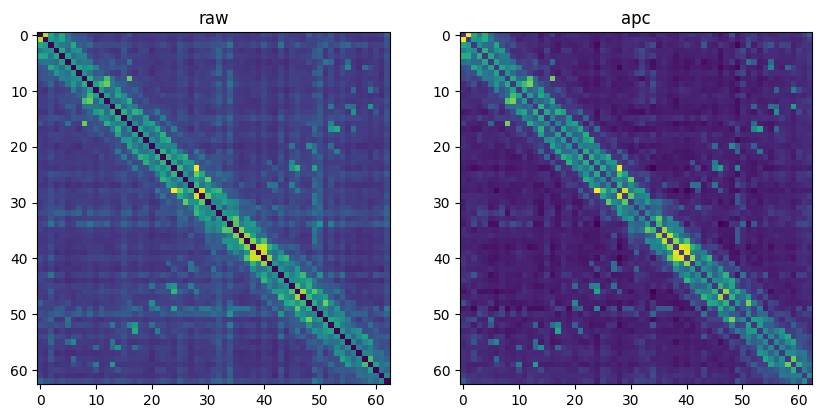

In [11]:
plt.figure(figsize=(10,5),dpi=100)
plt.subplot(1,2,1)
plt.title("raw")
plt.imshow(o_to_contacts(o_)[0])
plt.subplot(1,2,2)
plt.title("apc")
plt.imshow(o_to_contacts(o_)[1])
plt.show()